# Neural Networks in more details

Based on [cs231](http://cs231n.github.io/) by Stanford

In [1]:
import numpy as np

In [2]:
import matplotlib
import matplotlib.pyplot as plt
# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

## Recall the problem

### Moon data with Train/Test split

In [3]:
import sklearn.datasets

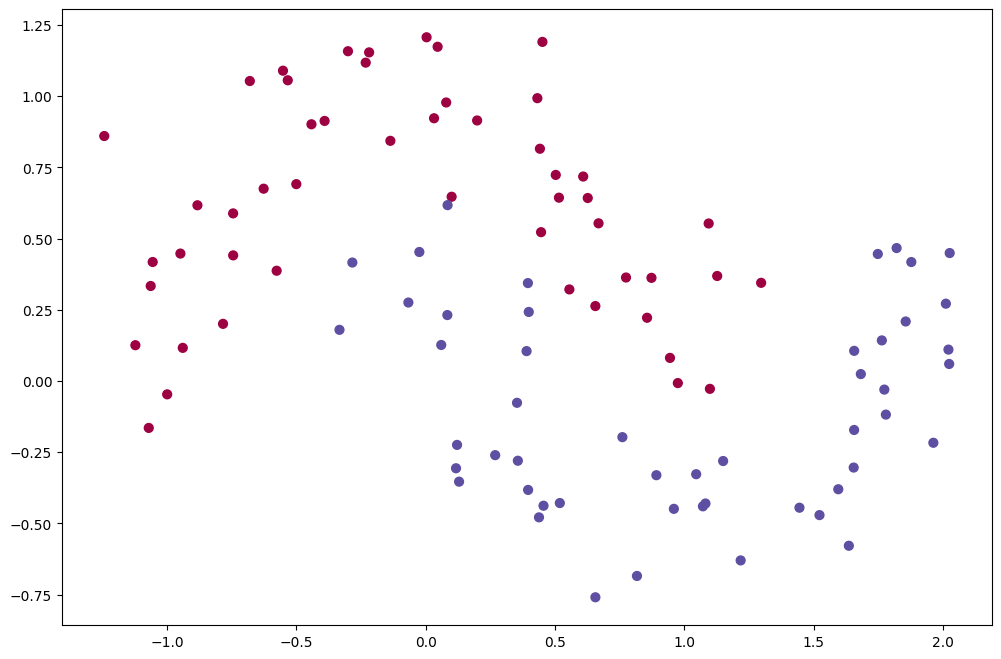

In [4]:
# Generate a dataset and plot it
X, y = sklearn.datasets.make_moons(100, shuffle=False, noise=0.2, random_state=42)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

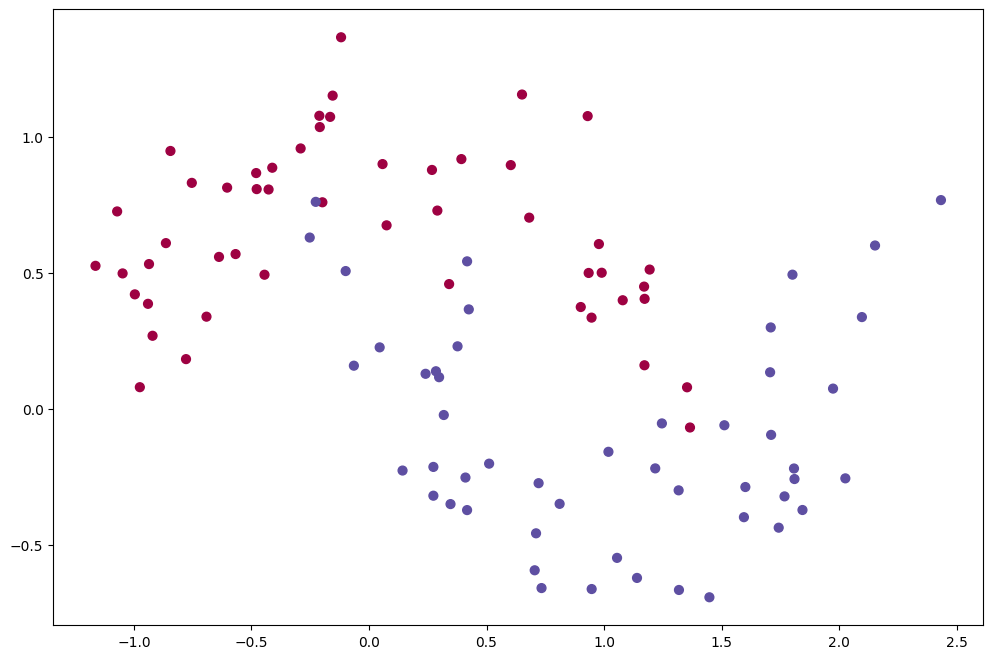

In [5]:
X_test, y_test = sklearn.datasets.make_moons(100, shuffle=False, noise=0.2, random_state=0)
plt.scatter(X_test[:,0], X_test[:,1], s=40, c=y_test, cmap=plt.cm.Spectral)

## MLP with Cross-entropy loss and softmax

### Softmax Function

Softmax function takes an N-dimensional vector of real numbers and transforms it into a vector of real number in range (0,1) which add upto 1

<img src="https://eli.thegreenplace.net/images/2016/softmax-layer-generic.png" alt="Softmax" style="width: 50%"/>



$$p_k = \dfrac{e^{f_k}}{\sum_{j} e^{f_j}}$$



### Cross-entropy loss

Cross entropy indicates the distance between what the model believes the output distribution should be, and what the original distribution really is. It is defined as:

$$H(y,p) = - \sum_i y_i log(p_i)$$



*Negative Log-Likelihood* (NLL):

<img src="https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log.png" alt="Softmax" style="width: 40%"/>




$$L(\mathbf{y}) = -\log(\mathbf{y})$$


<img src="https://ljvmiranda921.github.io/assets/png/cs231n-ann/neg_log_demo.png" alt="Softmax" style="width: 90%"/>

Let's take its **derivative**:

$$% <![CDATA[
\dfrac{\partial L_i}{\partial f_k} = \dfrac{\partial L_i}{\partial p_k} \dfrac{\partial p_k}{\partial f_k}$$
$$\dfrac{\partial L_i}{\partial p_k} = -\dfrac{1}{p_k}$$


Derivative of **softmax**:

let's $\Sigma = \sum_{j} e^{f_j}$

$$
\begin{eqnarray}
\dfrac{\partial p_k}{\partial f_k} &=& \dfrac{\partial}{\partial f_k} \left(\dfrac{e^{f_k}}{\sum_{j} e^{f_j}}\right) \\
&=& \dfrac{\Sigma \mathbf{D} e^{f_k} - e^{f_k} \mathbf{D} \Sigma}{\Sigma^2} \\
&=& \dfrac{e^{f_k}(\Sigma - e^{f_k})}{\Sigma^2}&=& \dfrac{e^{f_k}}{\Sigma} \dfrac{\Sigma - e^{f_k}}{\Sigma} \\
&=& p_k * (1-p_k)
\end{eqnarray}$$


By combining the two derivatives, we have:

$$% <![CDATA[
\begin{eqnarray}
\dfrac{\partial L_i}{\partial f_k} &=& \dfrac{\partial L_i}{\partial p_k} \dfrac{\partial p_k}{\partial f_k} \\
&=& -\dfrac{1}{p_k} (p_k * (1-p_k)) \\
&=& (p_k - 1)
\end{eqnarray} %]]>$$

Total loss is then defined as the average NLL over the training examples and the regularization:

$$L=\underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \frac{1}{2} \lambda \sum_k\sum_l W_{k,l}^2 }_\text{regularization loss}$$


In [6]:
N = X.shape[0] # number of points per class
D = X.shape[1] # input dimensionality
K = y.max() + 1 # number of classes

In [20]:
def activation(x, deriv=False):
    ## Sigmoid
    # if deriv:
    #     return activation(x) * (1 - activation(x))
    # return 1/(1 + np.exp(-x))

    ## ReLU
    if deriv:
        return np.where(x <= 0, 0, 1)
    return np.maximum(0, x)

In [8]:
def plot_decision_boundary(X, y, pred_func):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

In [9]:
# Helper function to predict an output (0 or 1)
def predict(W, b, x):
    hidden_layer = activation(np.dot(x, W[0]) + b[0])
    scores = np.dot(hidden_layer, W[1]) + b[1]
    return np.argmax(scores, axis=1)

In [28]:
# initialize parameters randomly
h = 20 # size of hidden layer
W = 1 * np.random.randn(D,h)
b = np.zeros((1,h))
W2 = 1 * np.random.randn(h,K)
b2 = np.zeros((1,K))


# some hyperparameters
step_size = 0.5
reg = 0.001 # regularization strength
dropout = 0.3
p_keep = 1 - dropout

# gradient descent loop
num_examples = X.shape[0]
for i in range(5000):

    # evaluate class scores, [N x K]
    z = np.dot(X, W) + b
    hidden_layer = activation(z) # get output of hidden layer
    if dropout > 0:
        U1 = (np.random.rand(*hidden_layer.shape) < p_keep) / p_keep # first dropout mask. Notice /p!
        hidden_layer *= U1 # drop!

    scores = np.dot(hidden_layer, W2) + b2

    # Softmax (compute the class probabilities)
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

    # compute the loss: average cross-entropy loss and regularization
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs)/num_examples
    reg_loss = 0.5*reg*np.sum(W*W) + 0.5*reg*np.sum(W2*W2)
    loss = data_loss
    if i % 1000 == 0:
        print("iteration %d: loss %f | train accuracy %f  | test accuracy %f | dead cells %f " % (
                i,
                loss,
                (np.mean(predict((W, W2), (b, b2), X) == y)),
                (np.mean(predict((W, W2), (b, b2), X_test) == y_test)),
                (hidden_layer < 0.000001).mean()
             ))


    # compute the gradient on scores
    dscores = probs.copy()
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples

    # backpropate the gradient to the parameters
    # first backprop into parameters W2 and b2
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)

    # next backprop into hidden layer
    dhidden = np.dot(dscores, W2.T)
    # backprop the ReLU non-linearity
    dhidden = dhidden * activation(z, deriv=True)

    if dropout > 0:
        dhidden *= U1 # drop!
        dhidden = dhidden / p_keep

    # finally into W,b
    dW = np.dot(X.T, dhidden)
    db = np.sum(dhidden, axis=0, keepdims=True)

    # add regularization gradient contribution
    dW2 += reg * W2
    dW += reg * W

    # perform a parameter update
    W += -step_size * dW
    b += -step_size * db
    W2 += -step_size * dW2
    b2 += -step_size * db2

iteration 0: loss 1.506678 | train accuracy 0.620000  | test accuracy 0.630000 | dead neurons 0.662000 
iteration 1000: loss 0.121310 | train accuracy 0.990000  | test accuracy 0.940000 | dead neurons 0.768500 
iteration 2000: loss 0.094397 | train accuracy 0.990000  | test accuracy 0.940000 | dead neurons 0.767000 
iteration 3000: loss 0.106468 | train accuracy 0.990000  | test accuracy 0.940000 | dead neurons 0.763000 
iteration 4000: loss 0.091222 | train accuracy 0.990000  | test accuracy 0.940000 | dead neurons 0.764500 


In [29]:
# hidden_layer

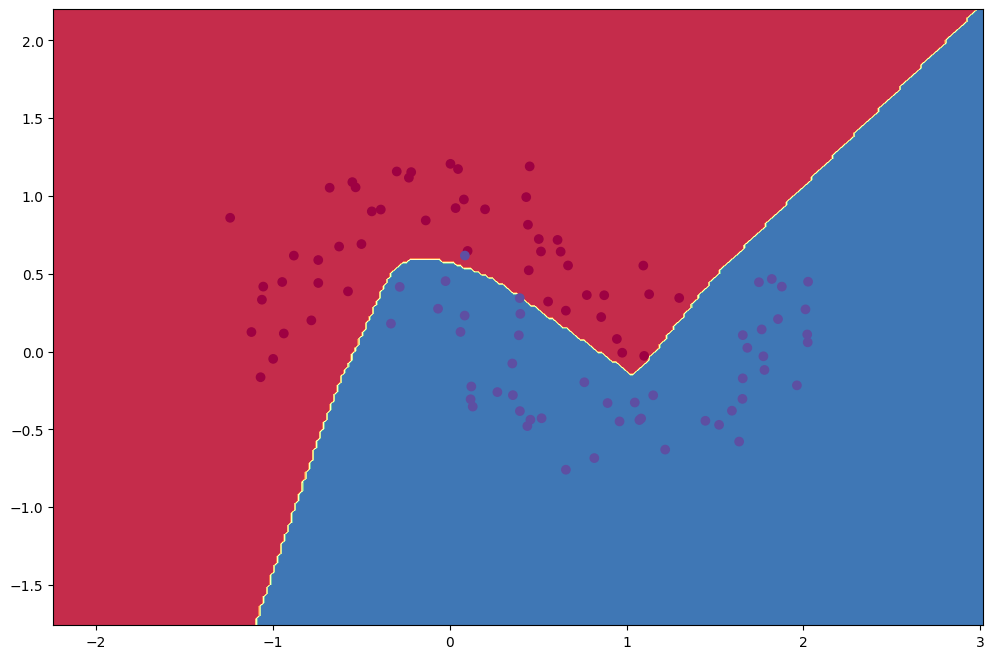

In [30]:
plot_decision_boundary(X, y, lambda x: predict((W, W2), (b, b2), x))

[Playground with NN](https://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=0&networkShape=4,2&seed=0.62004&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)

### Activations

<img src="https://miro.medium.com/max/2384/1*4ZEDRpFuCIpUjNgjDdT2Lg.png" alt="Activations" style="width: 80%"/>


*TLDR*: “What neuron type should I use?” Use the **ReLU** non-linearity, be careful with your learning rates and possibly monitor the fraction of “dead” units in a network. If this concerns you, try **Leaky ReLU**/**ELU**/**SELU**. Never use sigmoid.


### Representational power

It turns out that Neural Networks with at least one hidden layer are universal approximators. That is, it can be shown (e.g. see [Approximation by Superpositions of Sigmoidal Function from 1989 (pdf)](https://link.springer.com/article/10.1007/BF02551274), or this [intuitive explanation from Michael Nielsen](http://neuralnetworksanddeeplearning.com/chap4.html)) that given any continuous function $f(x)$ and some $ϵ>0$, there exists a Neural Network $g(x)$ with one hidden layer (with a reasonable choice of non-linearity, e.g. sigmoid) such that $ ∀x,∣f(x)−g(x)∣<ϵ $. In other words, the neural network can approximate any continuous function.





### Data Preprocessing

* Mean subtraction
* Normalization
* PCA and Whitening


<img src="http://cs231n.github.io/assets/nn2/prepro1.jpeg" alt="Normalization" style="width: 80%"/>
<img src="http://cs231n.github.io/assets/nn2/prepro2.jpeg" alt="PCA and Whitening" style="width: 80%"/>


### Regularizaion

* L1/L2 regularization
* Dropout
* Augmentations

<img src="http://cs231n.github.io/assets/nn2/dropout.jpeg" alt="Dropout" style="width: 50%"/>


### Parameter Initialization

1. ~~All zeros~~
1. ~~Constant~~
1. Small random numbers.
    * `scaling_coef * np.random.randn()` - Normal Distibution
    * `scaling_coef * (2* np.random.random() - 1)` - Uniformal Distibution
1. Calibrating the variances with 1/sqrt(n) for more details
    * `w = np.random.randn(n) / sqrt(n)` where n is the number of its inputs

    
**Initializing the biases.** It is possible and common to initialize the biases to be zero, since the asymmetry breaking is provided by the small random numbers in the weights. For ReLU non-linearities, some people like to use small constant value such as 0.01 for all biases because this ensures that all ReLU units fire in the beginning and therefore obtain and propagate some gradient. However, it is not clear if this provides a consistent improvement (in fact some results seem to indicate that this performs worse) and it is more common to simply use 0 bias initialization.

Check [this article](https://www.deeplearning.ai/ai-notes/initialization/) for more details


[**Batch Normalization Layer**](https://arxiv.org/abs/1502.03167)
Batch Normalization is a technique to provide any layer in a Neural Network with inputs that are zero mean/unit variance

Check [Understanding the backward pass through Batch Normalization Layer](https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)

### Parameter updates

* **Vanilla SGD**

```python
# Vanilla Minibatch Gradient Descent
data_batch = sample_training_data(data, 256) # sample 256 examples
weights_grad = evaluate_gradient(loss_fun, data_batch, weights)
weights += - learning_rate * weights_grad # perform parameter update</pre>
```

* Introduce **Momentum**:

```python
# Momentum update
v = mu * v - learning_rate * weights_grad # integrate velocity
weights += v # integrate position
```


<img src="http://cs231n.github.io/assets/nn3/nesterov.jpeg" alt="Optimization1" style="width: 80%;"/>


* **Nesterov’s Accelerated Momentum (NAG)** - SGD + Nesterov's Momentum

```python
weights_ahead = weights + mu * v
# evaluate dx_ahead (the gradient at weights_ahead instead of at weights)
v = mu * v - learning_rate * weights_ahead_grad
weights += v
```

Per-parameter adaptive learning rate methods:

* **Adagrad** - weights that receive high gradients will have their effective learning rate reduced, while weights that receive small or infrequent updates will have their effective learning rate increased. A downside of Adagrad is that in case of Deep Learning, the monotonic learning rate usually proves too aggressive and stops learning too early.

```python
cache += weights_grad**2
weights += - learning_rate * weights_grad / (np.sqrt(cache) + eps)
```

* **RMSprop** - RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate


```python
cache = decay_rate * cache + (1 - decay_rate) * weights_grad**2
weights += - learning_rate * weights_grad / (np.sqrt(cache) + eps)
```

* **ADAM** - **the default algorithm** to use, and often works slightly better than RMSProp. It looks a bit like RMSProp with momentum. However, it is often also worth trying SGD+Nesterov Momentum as an alternative. The full Adam update also includes a bias correction mechanism, which compensates for the fact that in the first few time steps the vectors *m*, *v* are both initialized and therefore biased at zero, before they fully “warm up”

```python
m = beta1*m + (1-beta1)*weights_grad
v = beta2*v + (1-beta2)*(weights_grad**2)
weights += - learning_rate * m / (np.sqrt(v) + eps)
```
    
Recommended values in the paper are `eps = 1e-8`, `beta1 = 0.9`, `beta2 = 0.999`.

<img src="http://cs231n.github.io/assets/nn3/opt2.gif" alt="Optimization1" style="width: 50%;"/>
<img src="http://cs231n.github.io/assets/nn3/opt1.gif" alt="Optimization2" style="width: 50%;"/>

Read more about optimizers here - http://cs231n.github.io/neural-networks-3/


### Learning rate

<img src="https://pbs.twimg.com/media/Fmc1YgWXoAM4Ch9?format=jpg&name=4096x4096" alt="Optimization1" style="width: 50%;"/>

Check more about dynamic learning rate here -  https://www.jeremyjordan.me/nn-learning-rate/

more [visualizations](https://dvgodoy.github.io/dl-visuals/Optimizers%20and%20Schedulers/)

 ## PyTorch

When training neural networks, the most frequently used algorithm is back propagation. In this algorithm, parameters (model weights) are adjusted according to the gradient of the loss function with respect to the given parameter.

To compute those gradients, PyTorch has a built-in differentiation engine called [torch.autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html). It supports automatic computation of gradient for any computational graph.


In [31]:
import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

<img src="https://pytorch.org/tutorials/_images/comp-graph.png" alt="Comp Graph" style="width: 50%;"/>

In [32]:
x, y

(tensor([1., 1., 1., 1., 1.]), tensor([0., 0., 0.]))

In [33]:
loss

tensor(1.2187, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [34]:
print('Gradient function for z =', z.grad_fn)
print('Gradient function for loss =', loss.grad_fn)

Gradient function for z = <AddBackward0 object at 0x7dbd44ae3bb0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7dbd44ae3b80>


In [35]:
w.grad

In [36]:
loss.backward()
print(w.grad)
print(b.grad)

tensor([[0.1743, 0.2848, 0.2093],
        [0.1743, 0.2848, 0.2093],
        [0.1743, 0.2848, 0.2093],
        [0.1743, 0.2848, 0.2093],
        [0.1743, 0.2848, 0.2093]])
tensor([0.1743, 0.2848, 0.2093])


## PyTorch: MNIST Classifier

In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', device)

Using PyTorch version: 2.0.1+cu118  Device: cpu


In [38]:
batch_size = 32

train_dataset = datasets.MNIST('./data',
                               train=True,
                               download=True,
                               transform=transforms.ToTensor())

validation_dataset = datasets.MNIST('./data',
                                    train=False,
                                    transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                                batch_size=batch_size,
                                                shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 100969512.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 29238642.00it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 32008679.86it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12751357.94it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [39]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [40]:
validation_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [41]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


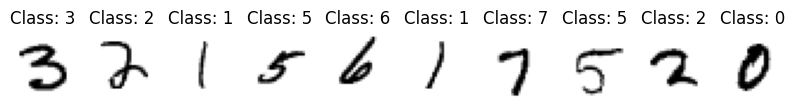

In [42]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

<img src="https://miro.medium.com/max/1400/1*HWhBextdDSkxYvz0kEMTVg.png" alt="Comp Graph" style="width: 50%;"/>

In [43]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 64)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) # map [batch_size, 1, 28, 28] -> [batch_size, 784]
        x = F.elu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.elu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x), dim=1)

model = Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = nn.NLLLoss()

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


In [44]:
def train(epoch, log_interval=200):
    # Set model to training mode
    model.train()

    # Loop over each batch from the training set
    train_loss, correct = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):

        # Zero gradient buffers
        optimizer.zero_grad()

        # Pass data through the network
        output = model(data)

        # Calculate loss
        loss = criterion(output, target)

        train_loss += loss.data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

        # Backpropagate
        loss.backward()

        # Update weights
        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

    train_loss /= len(train_loader)
    accuracy = 100. * correct.to(torch.float32) / len(train_loader.dataset)

    return train_loss, accuracy

In [45]:
def validate():
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)

    accuracy = 100. * correct.to(torch.float32) / len(validation_loader.dataset)

    return val_loss, accuracy

In [46]:
%%time
epochs = 10

lossv, accv = [], []
val_lossv, val_accv = [], []
for epoch in range(1, epochs + 1):
    train_loss, accuracy = train(epoch)
    lossv.append(train_loss)
    accv.append(accuracy)

    val_loss, val_accuracy = validate()
    val_lossv.append(val_loss)
    val_accv.append(val_accuracy)

    print('\nTrain set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        train_loss, accuracy))
    print('Validation set: Average loss: {:.4f}, Accuracy: ({:.0f}%)\n'.format(
        val_loss, val_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321311
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.457862
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.654489
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.676566
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.570611
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.594868
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.383940
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.691771
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.196528
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.179521

Train set: Average loss: 0.7070, Accuracy: (81%)

Validation set: Average loss: 0.3294, Accuracy: (90%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.414839
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.444678
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.433789
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.160448
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.174496
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.299155
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.164908
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.625597
Train 

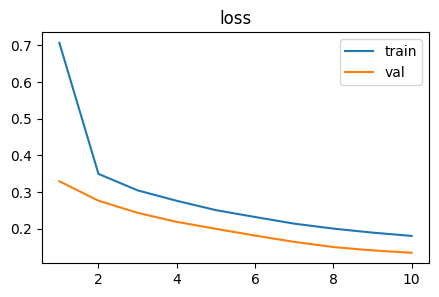

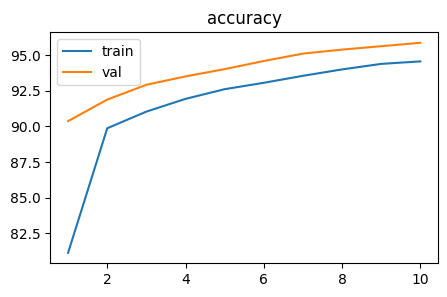

In [47]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv, label='train')
plt.plot(np.arange(1,epochs+1), val_lossv, label='val')
plt.title('loss')
plt.legend()

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv, label='train')
plt.plot(np.arange(1,epochs+1), val_accv, label='val')
plt.title('accuracy');
plt.legend()

In [50]:
dataiter = iter(validation_loader)

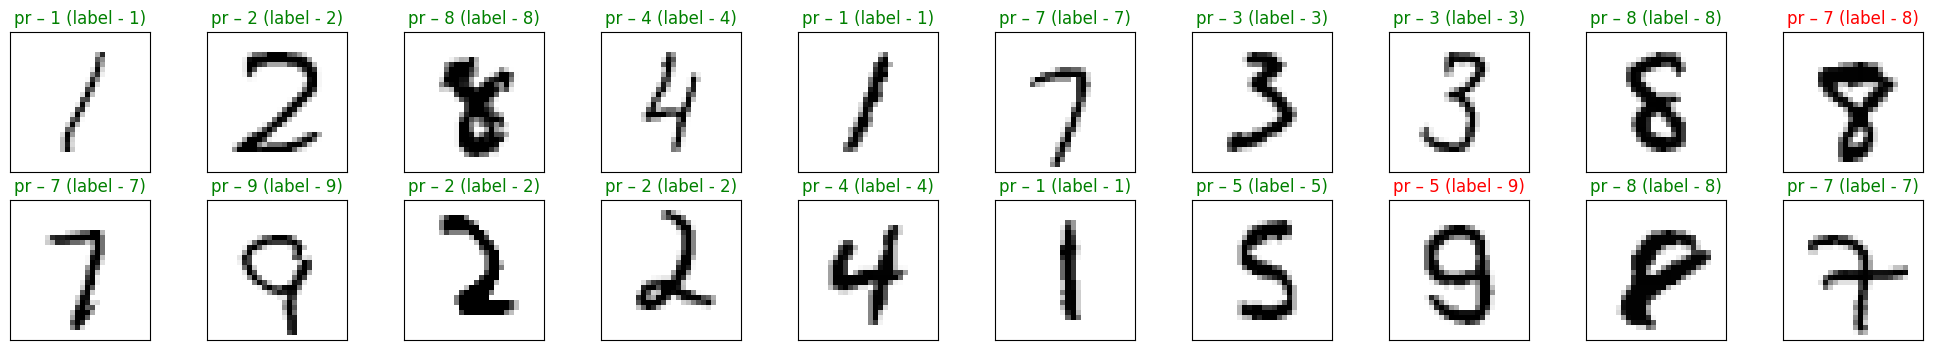

In [60]:
images, labels = next(dataiter)
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray_r')
    ax.set_title("pr – {} (label - {})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [54]:
torch.save(model, 'mnist.pt') # you can visualize your model in https://netron.app/

---